# Image classification

In [ ]:
import matplotlib.pyplot as plt
# For plotting and visualizing data
import numpy as np
# For numerical operations
import PIL
# Python Imaging Library for image processing
import tensorflow as tf
# TensorFlow for deep learning

# Import specific modules from TensorFlow and Keras
from tensorflow import keras
# High-level API for building and training models
from tensorflow.keras import layers
# For creating layers in neural networks
from tensorflow.keras.models import Sequential
# For creating sequential models

## Download and explore the dataset

This is a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib  # For working with file paths

# URL of the dataset to be downloaded
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Download and extract the dataset.
# The get_file function returns the file path.
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)

# Convert the file path to a pathlib Path object and remove the
# file extension.
data_dir = pathlib.Path(data_dir).with_suffix('')


In [ ]:
# Count the number of image files in the dataset directory
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)  # Print the total number of images

3670


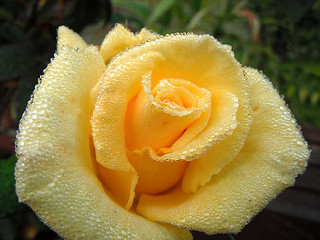

In [ ]:
# Get a list of all the images in the 'roses' subdirectory
roses = list(data_dir.glob('roses/*'))

# Open the first image in the 'roses' subdirectory using PIL
PIL.Image.open(str(roses[100]))

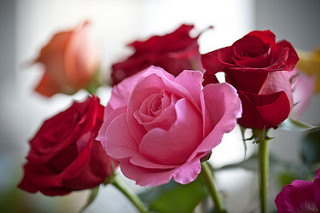

In [ ]:
# Open the second image in the 'roses' subdirectory using PIL
PIL.Image.open(str(roses[101]))

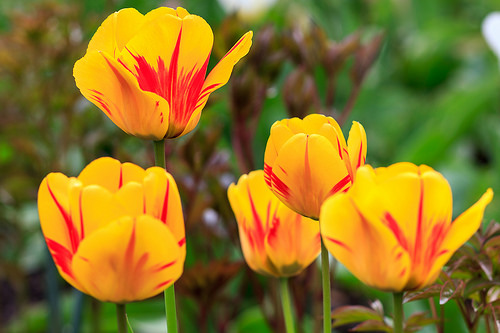

In [ ]:
# Get a list of all the images in the 'tulips' subdirectory
tulips = list(data_dir.glob('tulips/*'))

# Open the first image in the 'tulips' subdirectory using PIL
PIL.Image.open(str(tulips[0]))

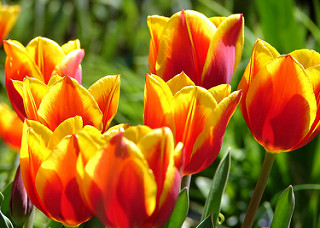

In [ ]:
# Open the second image in the 'tulips' subdirectory using PIL
PIL.Image.open(str(tulips[1]))

### Create a dataset

Define some parameters for the loader:

In [ ]:
# Let's establish data loading information
# Set the batch size for training and evaluation
batch_size = 32

# Set the height and width for resizing images
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [ ]:
# Create a training dataset from the images in the specified
# directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  # Directory containing the dataset
  validation_split=0.2,
  # Split the data: 80% training, 20% validation
  subset="training",
  # Specify that this is the training subset
  seed=123,
  # Seed for reproducibility
  image_size=(img_height, img_width),
  # Resize images to the specified height and width
  batch_size=batch_size
  # Number of images to return in each batch
)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
# Create a validation dataset from the images in the specified
# directory
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  # Directory containing the dataset
  validation_split=0.2,
  # Split the data: 80% training, 20% validation
  subset="validation",
  # Specify that this is the validation subset
  seed=123,
  # Seed for reproducibility
  image_size=(img_height, img_width),
  # Resize images to the specified height and width
  batch_size=batch_size
  # Number of images to return in each batch
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# Get the class names from the training dataset
class_names = train_ds.class_names

# Print the class names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

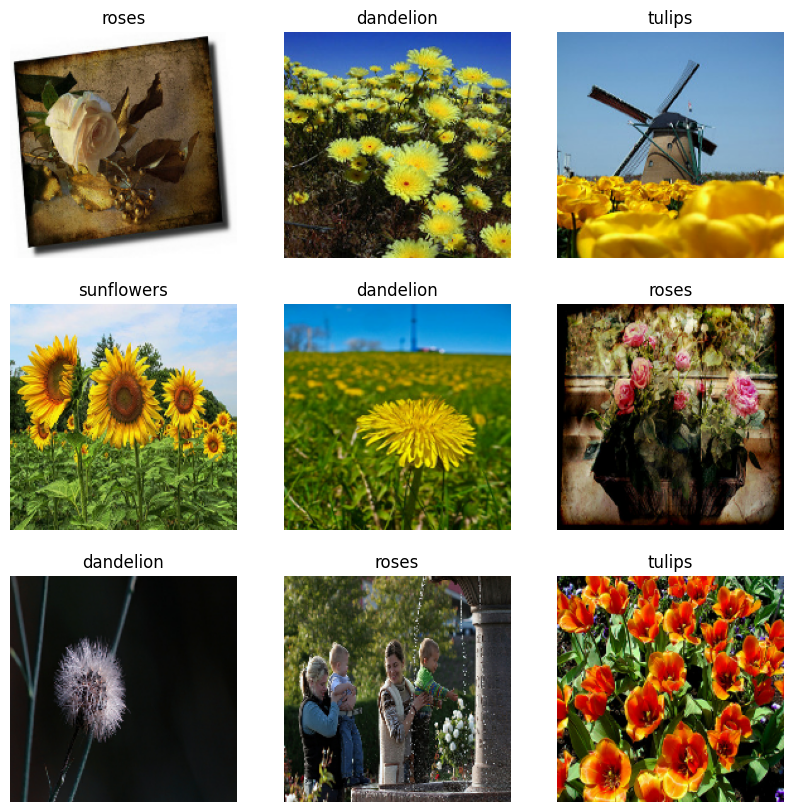

In [ ]:
import matplotlib.pyplot as plt  # For plotting and visualizing
# data

# Create a figure for displaying a grid of images
plt.figure(figsize=(10, 10))

# Iterate over a batch of images and labels from the training
# dataset
for images, labels in train_ds.take(1):
  for i in range(9):  # Display the first 9 images
    ax = plt.subplot(3, 3, i + 1)
    # Create a subplot in a 3x3 grid
    plt.imshow(images[i].numpy().astype("uint8"))
    # Display the image
    plt.title(class_names[labels[i]])
    # Set the title to the class name
    plt.axis("off")  # Hide the axis

In [ ]:
# Iterate over batches of images and labels from the training
# dataset
for image_batch, labels_batch in train_ds:
  # Print the shape of the image batch
  print(image_batch.shape)

  # Print the shape of the labels batch
  print(labels_batch.shape)

  # Break after the first batch to avoid printing all batches
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [ ]:
# Set AUTOTUNE to automatically tune the prefetch buffer size
AUTOTUNE = tf.data.AUTOTUNE

# Cache the training dataset, shuffle it, and prefetch batches
# for performance optimization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Cache the validation dataset and prefetch batches for
# performance optimization
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
# Create a normalization layer to scale pixel values to
# the range [0, 1]
normalization_layer = layers.Rescaling(1./255)

In [ ]:
# Apply the normalization layer to the training dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Get a batch of normalized images and labels
image_batch, labels_batch = next(iter(normalized_ds))

# Select the first image from the batch
first_image = image_batch[0]

# Print the minimum and maximum pixel values of the first image
# to verify normalization
# Notice the pixel values are now in the range [0, 1].
print(np.min(first_image), np.max(first_image))

0.0 1.0


## A basic Keras model

In [ ]:
#ReLU allows neural networks to learn more complex patterns,
  # avoid some common issues like vanishing gradients,
  # and do so efficiently, making it one of the most popular
  # activation functions in deep learning models.

# Get the number of classes from the class names
num_classes = len(class_names)

# Define the model architecture using the Sequential API
model = Sequential([
  # Normalization layer to scale pixel values to the range [0, 1]
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # First convolutional layer with 16 filters, 3x3 kernel size,
  # 'same' padding, and ReLU activation
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  # Max pooling layer

  # Second convolutional layer with 32 filters, 3x3 kernel size,
  # 'same' padding, and ReLU activation
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  # Max pooling layer

  # Third convolutional layer with 64 filters, 3x3 kernel size,
  # 'same' padding, and ReLU activation
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  # Max pooling layer

  # Flatten the feature maps to a 1D vector
  layers.Flatten(),

  # Fully connected layer with 128 units and ReLU activation
  layers.Dense(128, activation='relu'),

  # Output layer with a unit for each class
  layers.Dense(num_classes)
])

In [ ]:
# Compile the model with the Adam optimizer,
# sparse categorical cross-entropy loss, and accuracy metric
model.compile(
    optimizer='adam',  # Optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # Loss function
    metrics=['accuracy']
    # Metrics to monitor during training and evaluation
)

In [ ]:
# Print a summary of the model architecture
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 64)       

In [ ]:
# Set the number of epochs for training
epochs = 10

# Train the model using the training dataset and
# validate using the validation dataset
history = model.fit(
  train_ds,  # Training data
  validation_data=val_ds,  # Validation data
  epochs=epochs  # Number of epochs to train
)

Epoch 1/10
92/92 [==============================] - 5s 35ms/step - loss: 1.3940 - accuracy: 0.3941 - val_loss: 1.1219 - val_accuracy: 0.5368
Epoch 2/10
92/92 [==============================] - 2s 22ms/step - loss: 0.9975 - accuracy: 0.6059 - val_loss: 1.0195 - val_accuracy: 0.5940
Epoch 3/10
92/92 [==============================] - 2s 21ms/step - loss: 0.8603 - accuracy: 0.6713 - val_loss: 0.9357 - val_accuracy: 0.6281
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.6940 - accuracy: 0.7374 - val_loss: 0.8793 - val_accuracy: 0.6499
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.5031 - accuracy: 0.8239 - val_loss: 1.0109 - val_accuracy: 0.6403
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.3386 - accuracy: 0.8781 - val_loss: 1.0337 - val_accuracy: 0.6730
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.1779 - accuracy: 0.9441 - val_loss: 1.2911 - val_accuracy: 0.6376
Epoch 8/10
92

## Visualize training results

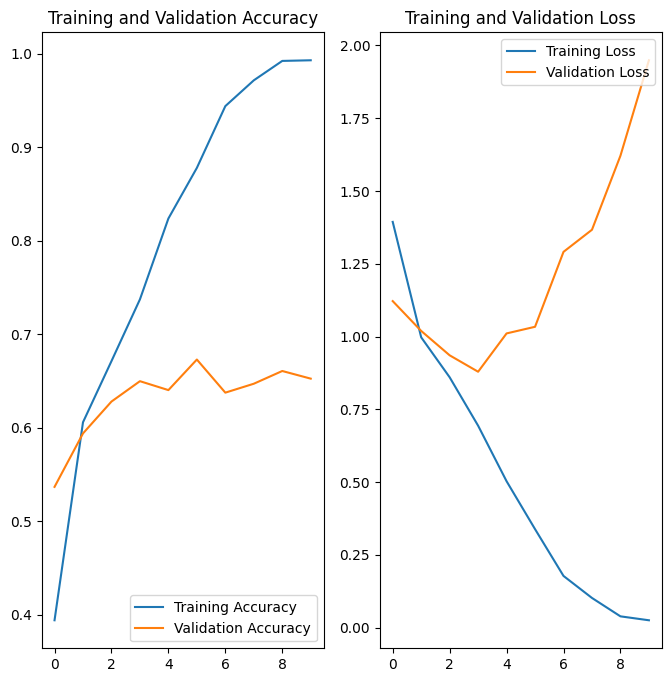

In [ ]:
# Extract accuracy and loss metrics from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for plotting
epochs_range = range(epochs)

# Create a figure for plotting
plt.figure(figsize=(8, 8))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots
plt.show()

In [ ]:
# Define a data augmentation pipeline using the Sequential API
# this allows to improve generalization
data_augmentation = keras.Sequential([
    # Randomly flip the images horizontally
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),

    # Randomly rotate the images by 10%
    layers.RandomRotation(0.1),

    # Randomly zoom into the images by 10%
    layers.RandomZoom(0.1),
])

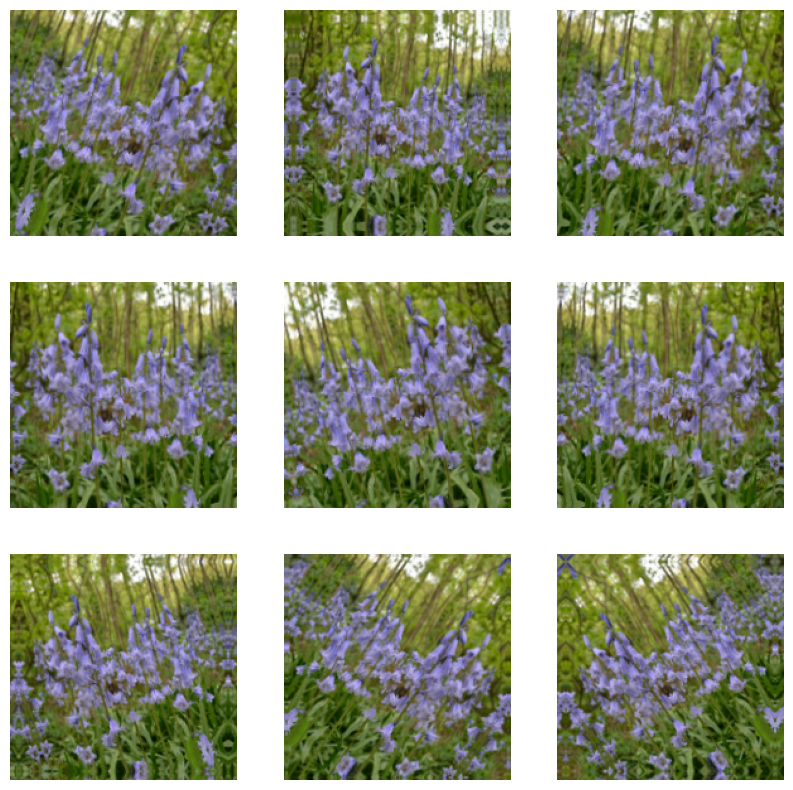

In [ ]:
# Create a figure for displaying augmented images
plt.figure(figsize=(10, 10))

# Take a batch of images from the training dataset
for images, _ in train_ds.take(1):
  # Apply data augmentation to the images and display the
  # first 9 augmented images
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")  # Hide the axis

In [ ]:
# Define the model architecture using the Sequential API
model = Sequential([
  # Data augmentation layer
  data_augmentation,

  # Normalization layer to scale pixel values to the range [0, 1]
  layers.Rescaling(1./255),

  # First convolutional layer with 16 filters, 3x3 kernel size,
  # 'same' padding, and ReLU activation
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  # Max pooling layer

  # Second convolutional layer with 32 filters, 3x3 kernel size,
  # 'same' padding, and ReLU activation
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  # Max pooling layer

  # Third convolutional layer with 64 filters, 3x3 kernel size,
  # 'same' padding, and ReLU activation
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  # Max pooling layer

  # Dropout layer to reduce overfitting, with a dropout rate of 0.2
  layers.Dropout(0.2),

  # Flatten the feature maps to a 1D vector
  layers.Flatten(),

  # Fully connected layer with 128 units and ReLU activation
  layers.Dense(128, activation='relu'),

  # Output layer with a unit for each class, named "outputs"
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [ ]:
# Compile the model with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy metric
model.compile(
    optimizer='adam',  # Optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Loss function
    metrics=['accuracy']  # Metrics to monitor during training and evaluation
)

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [ ]:
# Set the number of epochs for training
epochs = 20

# Train the model using the training dataset and validate using the validation dataset
history = model.fit(
  train_ds,  # Training data
  validation_data=val_ds,  # Validation data
  epochs=epochs  # Number of epochs to train
)

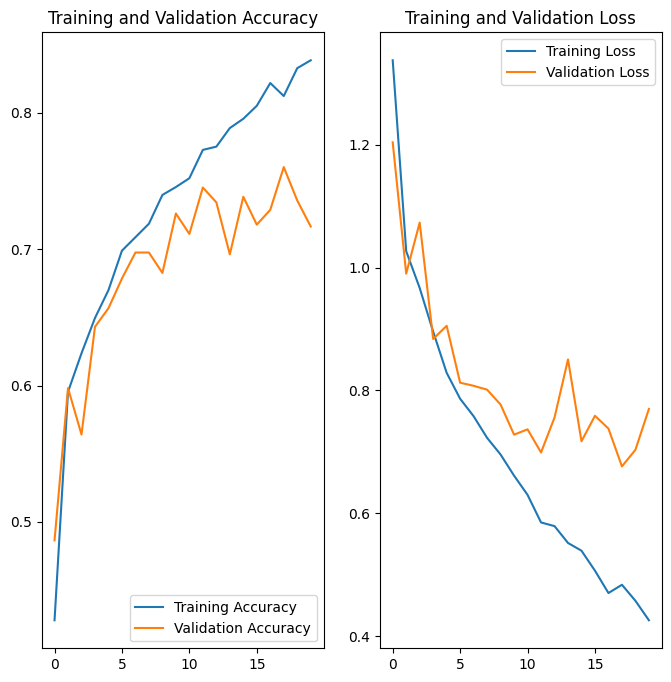

In [ ]:
# Extract accuracy and loss metrics from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for plotting
epochs_range = range(epochs)

# Create a figure for plotting
plt.figure(figsize=(8, 8))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots
plt.show()

In [ ]:
# Download an image of a sunflower from the specified URL
sunflower_url = "https://cdn.britannica.com/44/174644-050-774B8DD6/Close-up-head-sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Tulip', origin=sunflower_url)

# Load the image and resize it to the target size
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

# Convert the image to a numpy array
img_array = tf.keras.utils.img_to_array(img)

# Expand the dimensions of the image to create a batch of size 1
img_array = tf.expand_dims(img_array, 0)

# Make a prediction using the model
predictions = model.predict(img_array)

# Apply softmax to the predictions to get the class probabilities
score = tf.nn.softmax(predictions[0])

# Print the class with the highest confidence
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 77ms/step
This image most likely belongs to tulips with a 95.95 percent confidence.
